## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the French/GLACIOCLIM dataset. B. part is transfer learning with Swiss/GLAMOS train set and French/GLACIOCLIM test set

### Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
# Set dataPath with home directory of data
cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_glacioclim = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim.columns


Number of glaciers: 8
Number of winter, summer and annual samples: 10495
Number of annual samples: 4518
Number of winter samples: 3281
Number of summer samples: 2696


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_glacioclim_test = data_glacioclim.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data


2025-06-17 11:00:29,319 - INFO - Loaded preprocessed data.
2025-06-17 11:00:29,320 - INFO - Number of monthly rows: 90810
2025-06-17 11:00:29,334 - INFO - Number of annual samples: 54121
2025-06-17 11:00:29,340 - INFO - Number of summer samples: 12747
2025-06-17 11:00:29,347 - INFO - Number of winter samples: 23942


#### A.2. Dataset statistics

In [ ]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

In [ ]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink,  color_orange])
plt.title('Number of measurements per year for all glaciers')


In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)


In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'FR4N01235A08 dArgentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [ ]:
test_glaciers = ['FR4N01146D09+E06 Gebroulaz']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))



##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

region_name='Prediction most recent 10 years'



##### A.3.3. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink, color_orange], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink, color_orange], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Gebroulaz_reworked_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Gebroulaz_reworked_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

###### Results

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=True)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name=test_set["splits_vals"], include_summer = True)   

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 3)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [ 'geb_summer_smb_abl_2016_ablation_setup2013_13',
             'geb_summer_smb_abl_2017_ablation_setup2016_10'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### B.1. Train CH Test FR

In [3]:
# Read in
data_FR = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
# Adjust dfs to match
data_CH['GLACIER_ZONE'] = 'Placeholder'
data_CH['DATA_MODIFICATION'] = ''
data_CH = data_CH.drop(columns=['aspect_sgi', 'slope_sgi', 'topo_sgi'], errors='ignore')

data_FR = data_FR[data_FR['PERIOD'] != 'summer']

# Merge FR with CH
data_FR_CH = pd.concat([data_FR, data_CH], axis=0).reset_index(drop=True)

display(len(data_FR_CH['GLACIER'].unique()))

47

In [4]:
# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_FR_CH,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'FR_CH_wgms_dataset_monthly_full.csv')
data_monthly_FR_CH = dataloader_gl.data

display(data_monthly_FR_CH.head(2))

2025-06-17 11:01:02,290 - INFO - Loaded preprocessed data.
2025-06-17 11:01:02,293 - INFO - Number of monthly rows: 368745
2025-06-17 11:01:02,340 - INFO - Number of annual samples: 141561
2025-06-17 11:01:02,394 - INFO - Number of winter samples: 227184


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369


In [5]:
test_glaciers = list(data_FR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))



Size of test data: 78063
Size of train data: 290682
Percentage of test size: 26.86%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (8) ['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets']


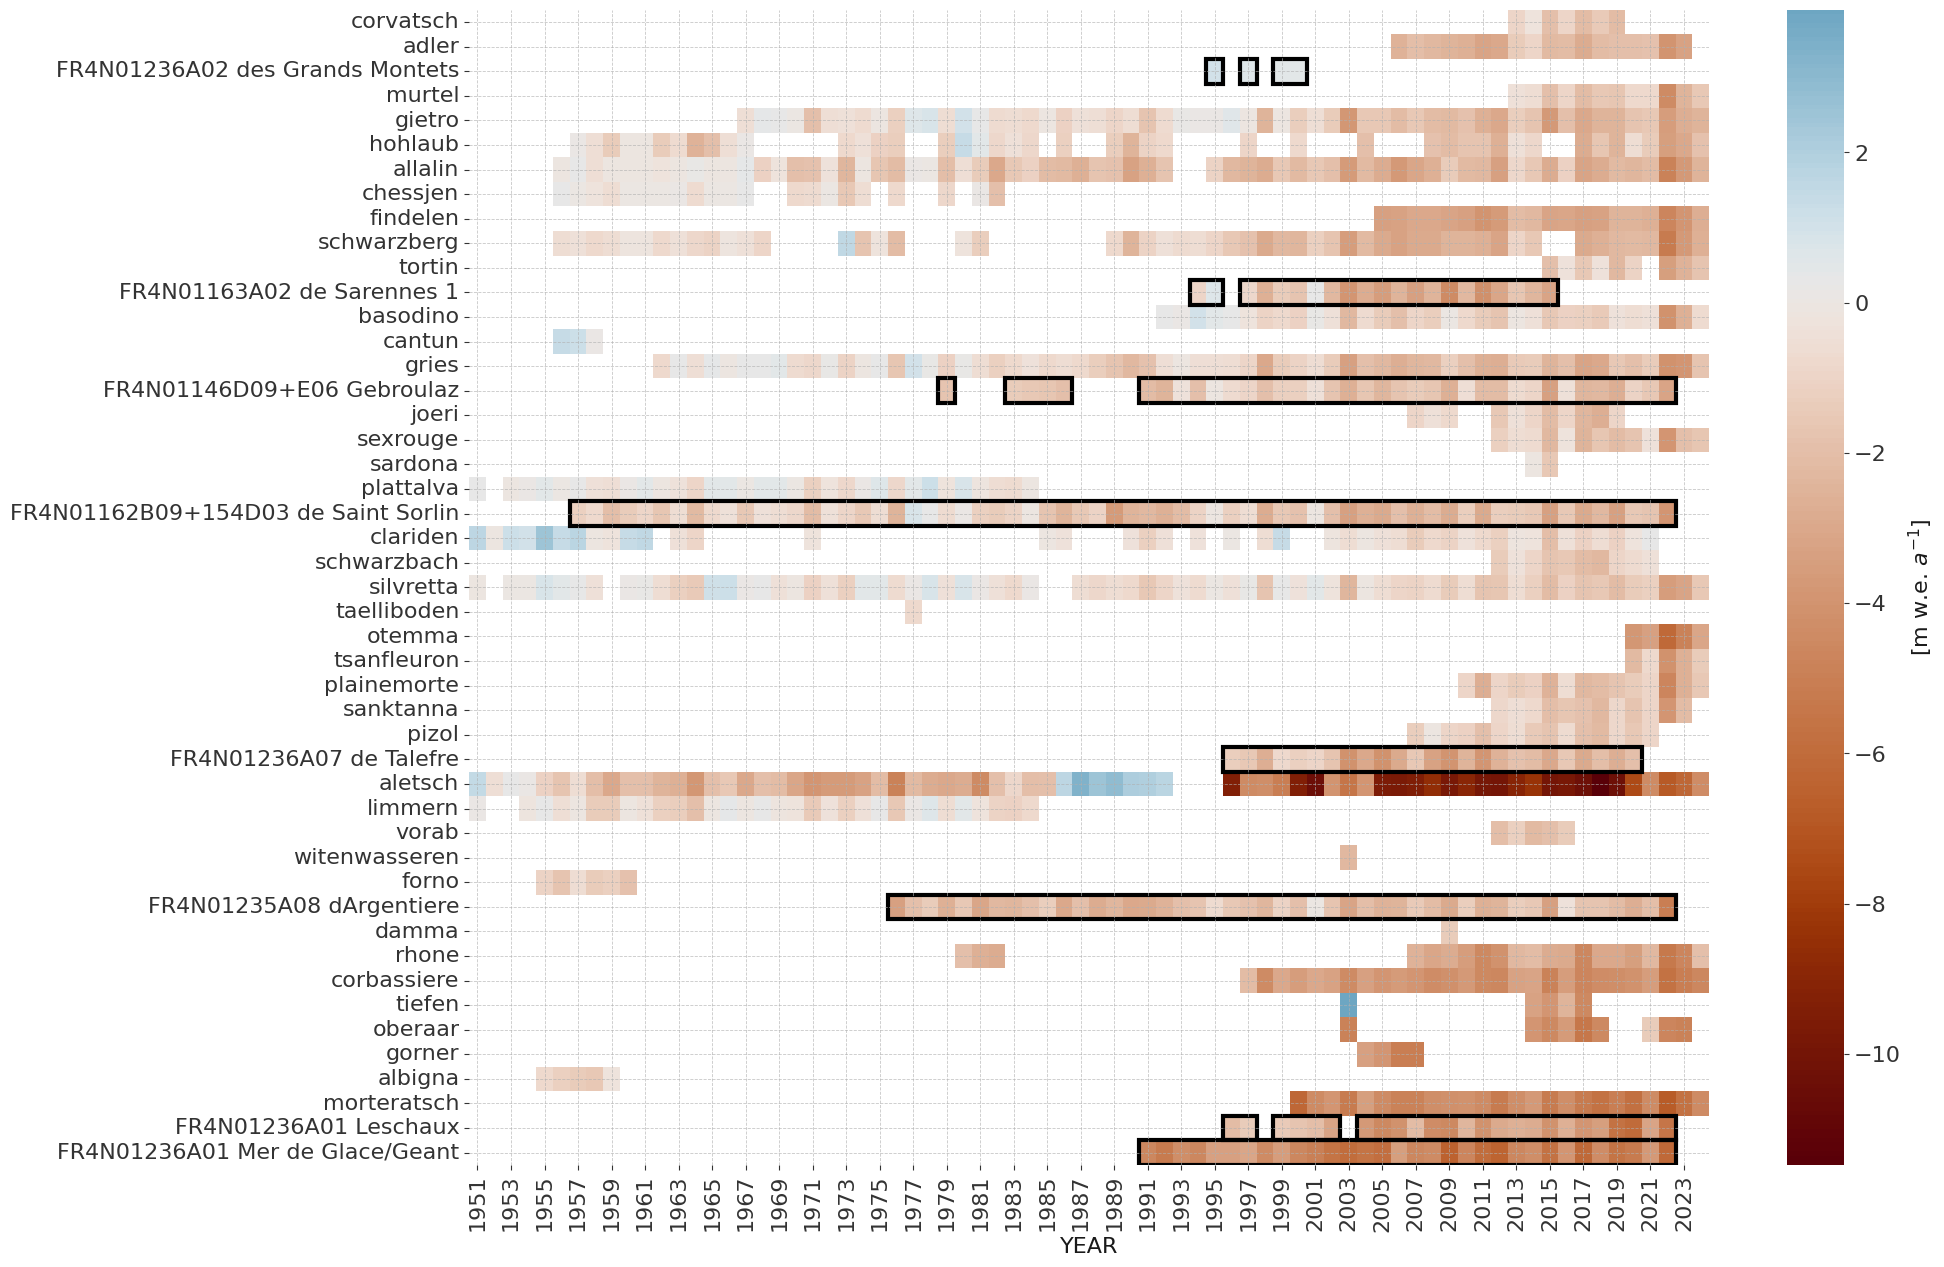

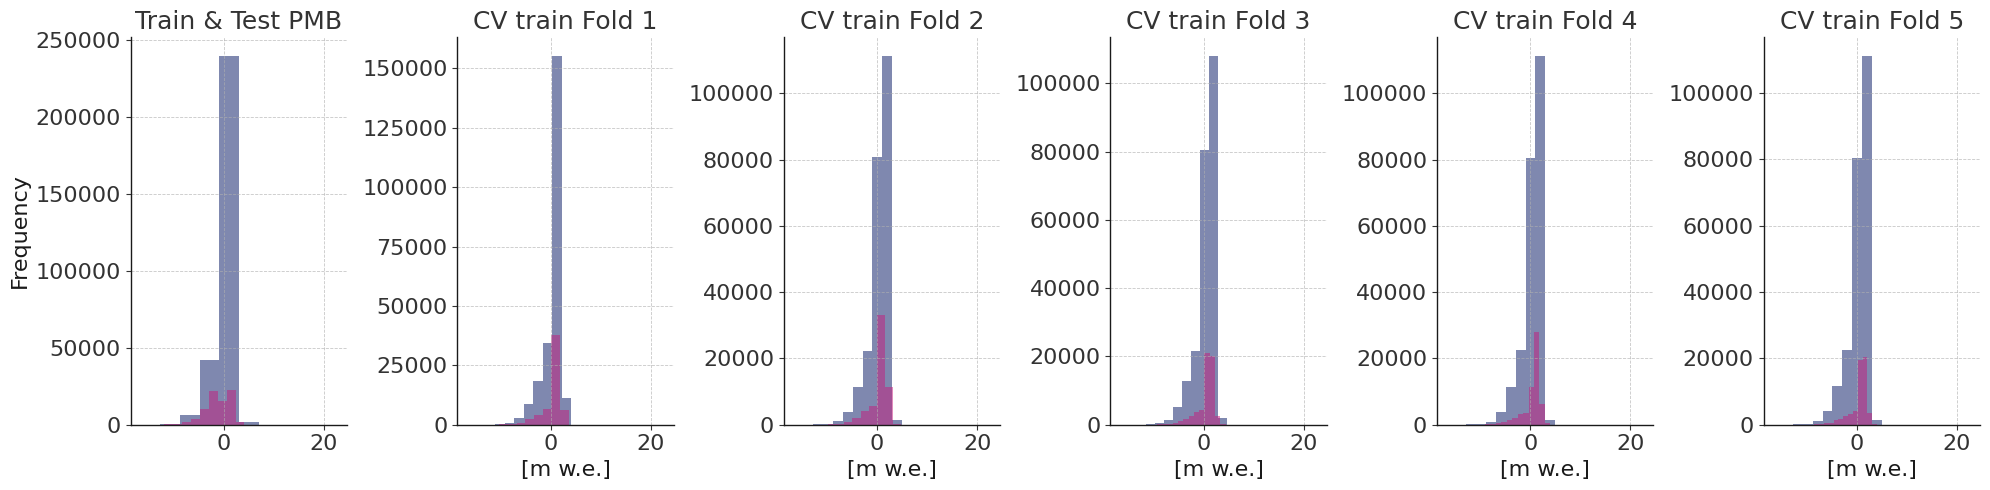

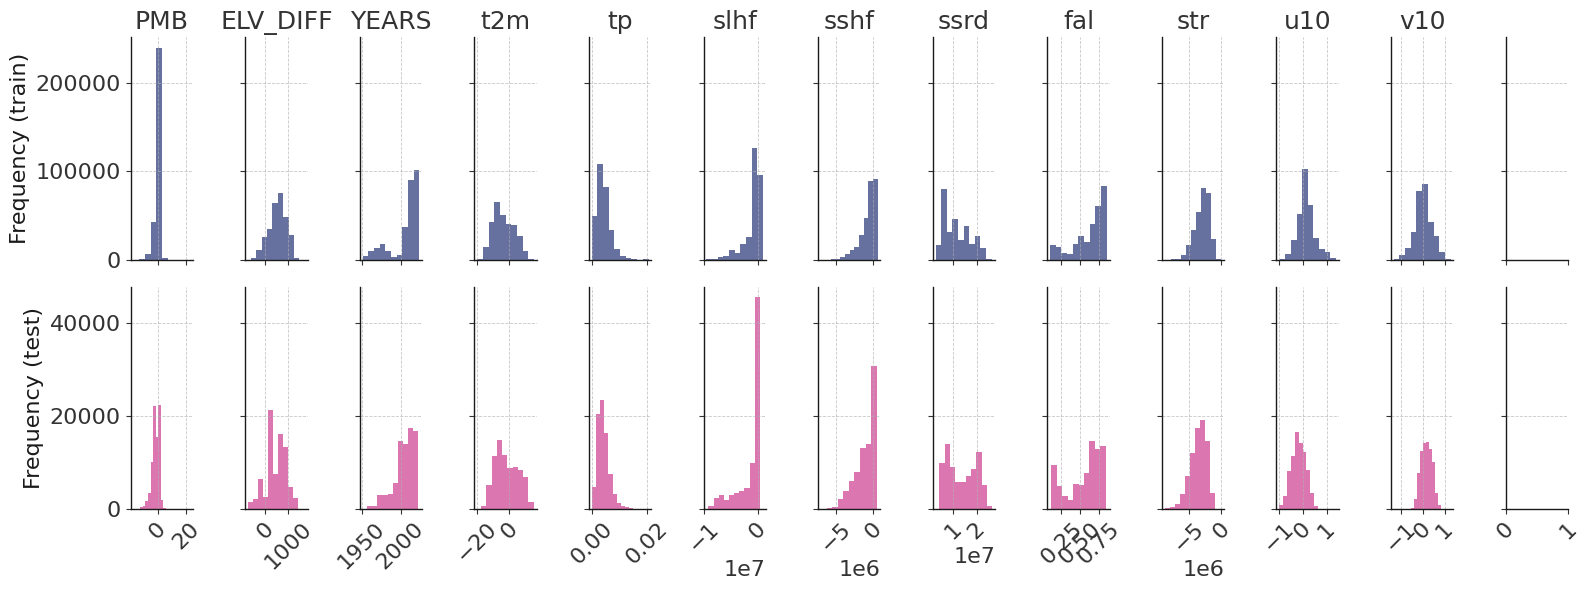

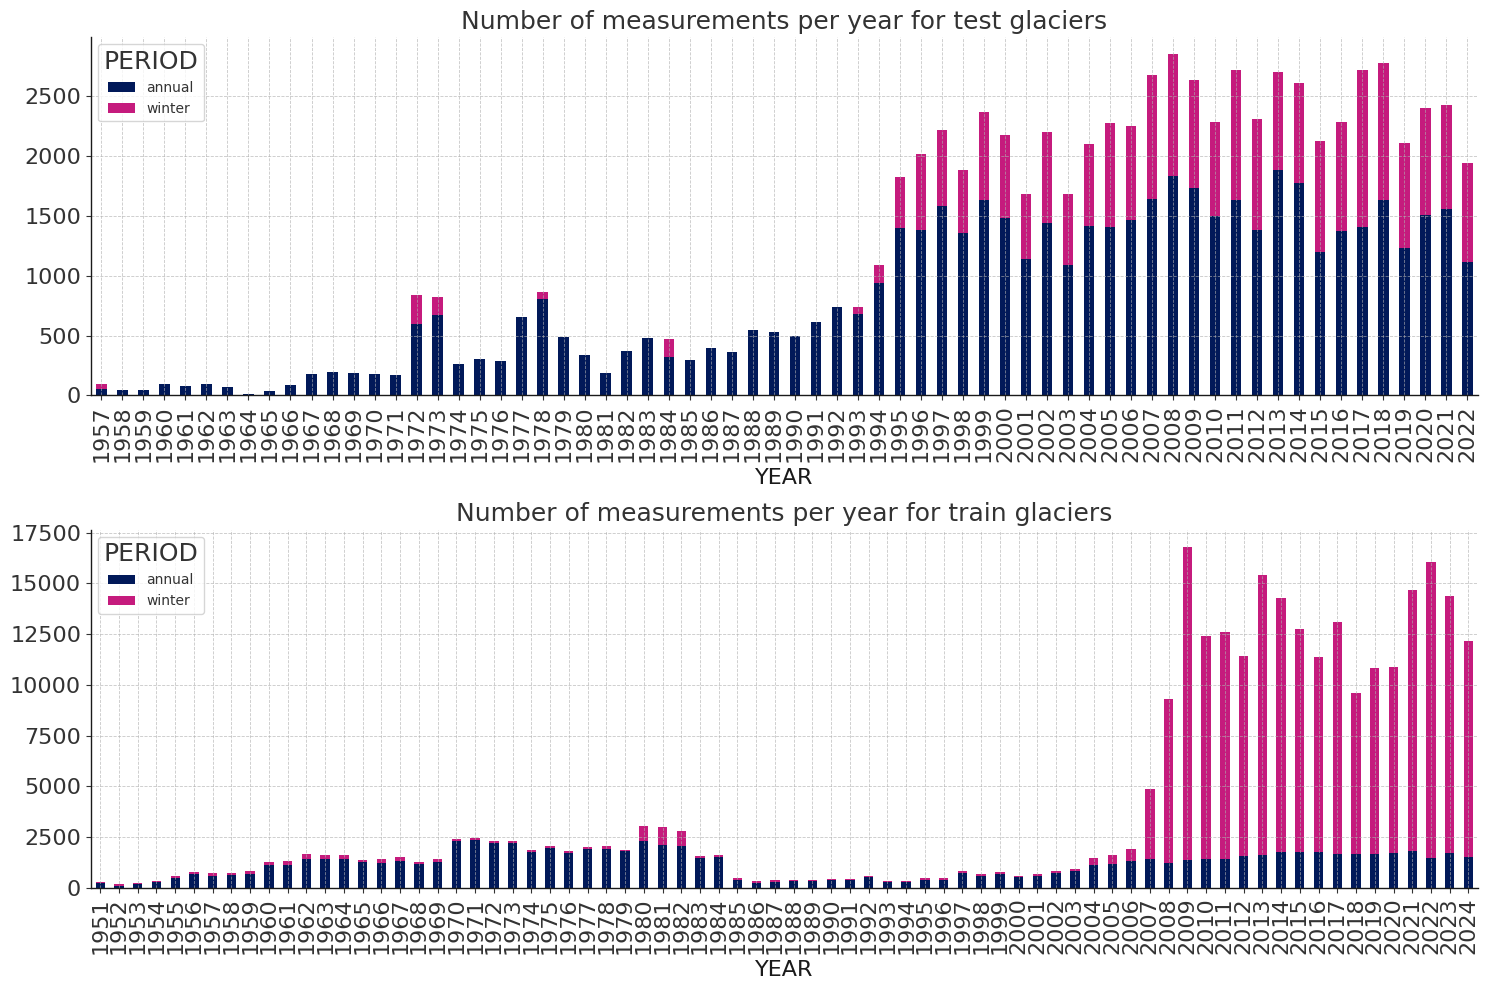

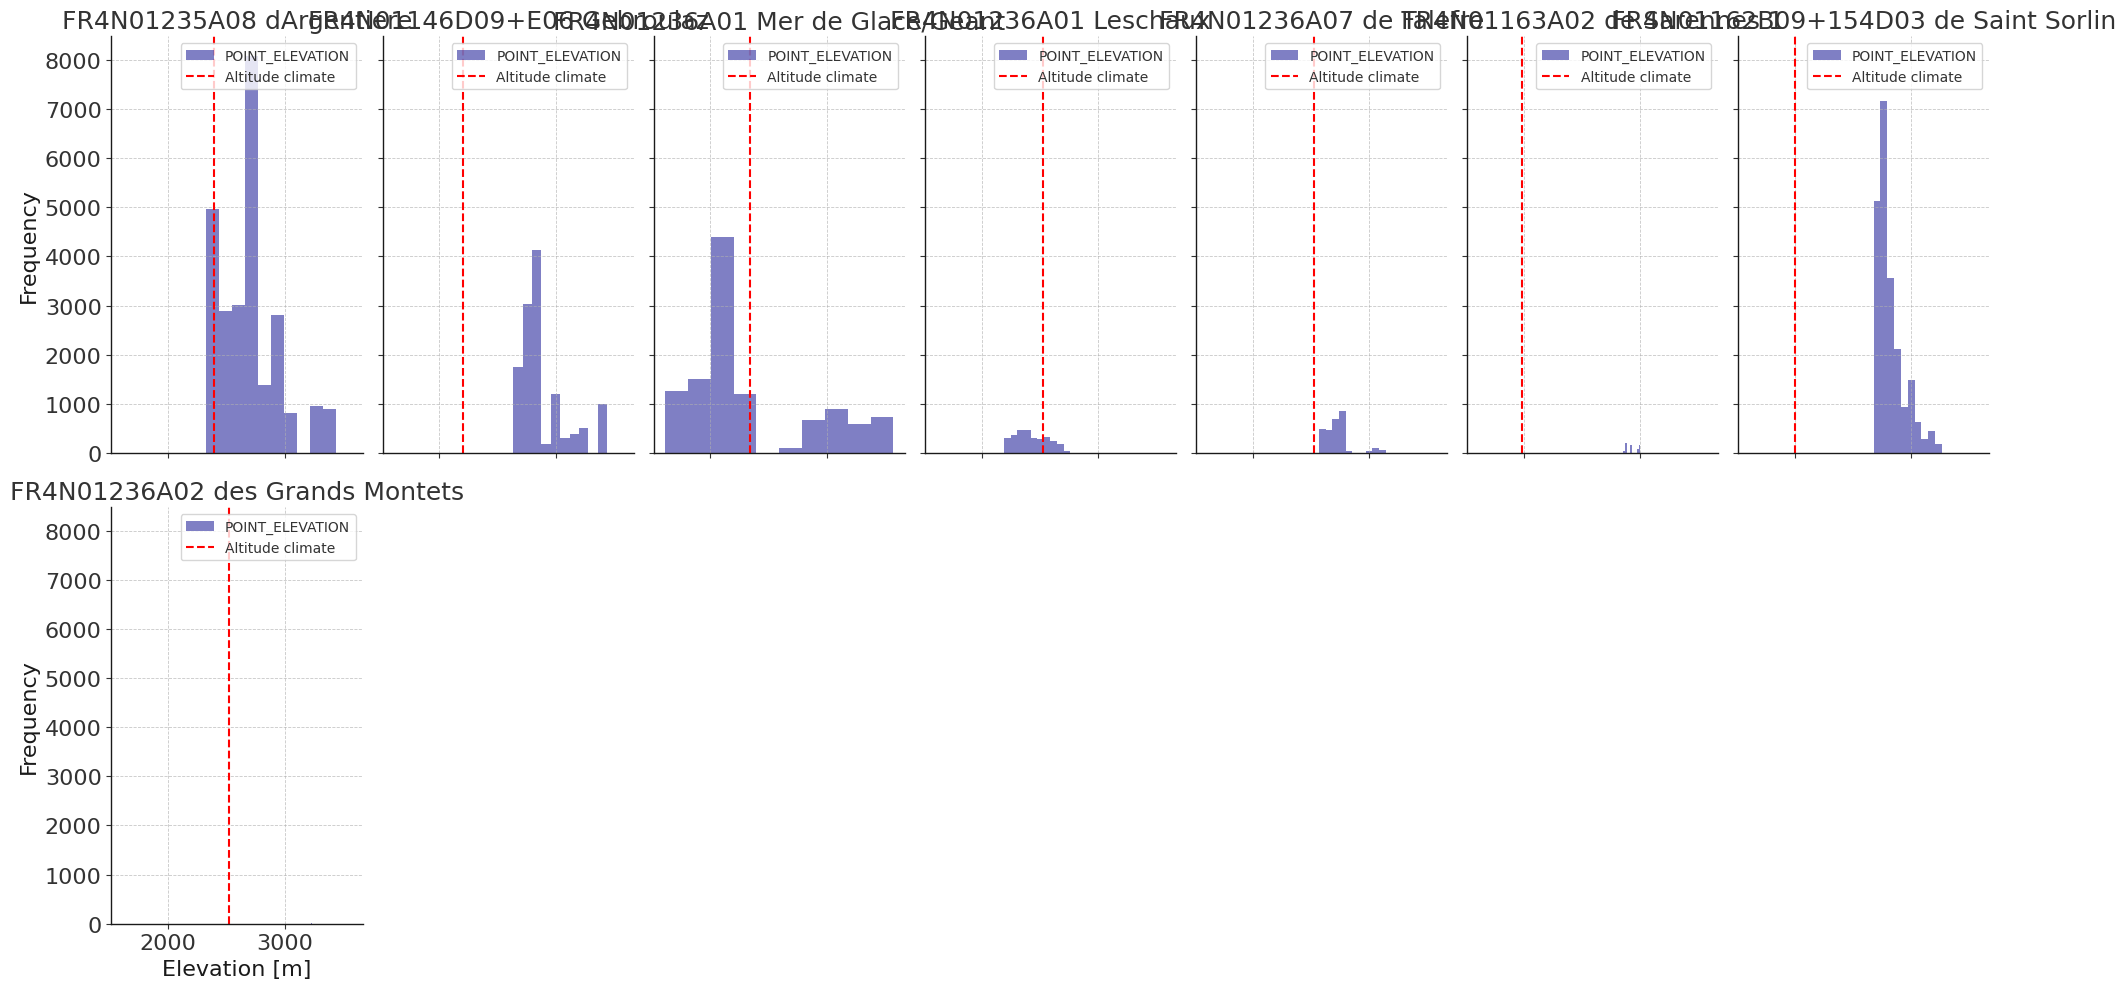

In [6]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.2.2. XGBoost Transfer Region

In [7]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [8]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_FR_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_FR_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 27)
Shape of testing dataset: (78063, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.195614192191449
Shape of the test: (78063, 15)
Overall score: 1.6878425496741187
CPU times: user 5.79 s, sys: 110 ms, total: 5.9 s
Wall time: 556 ms


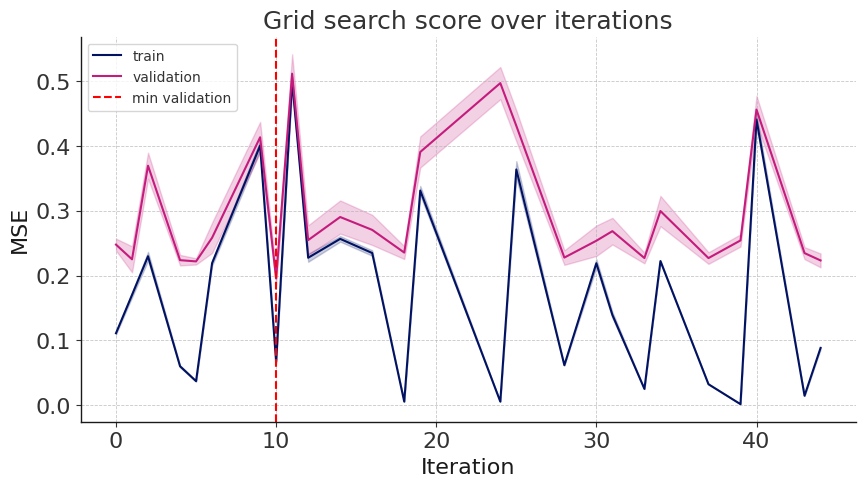

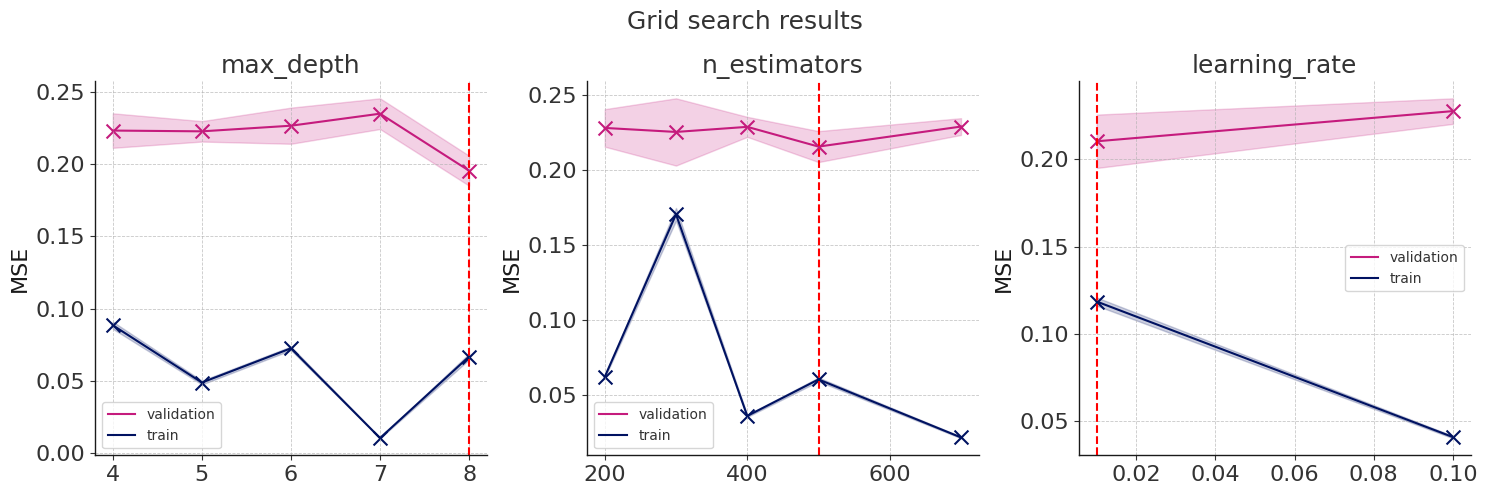

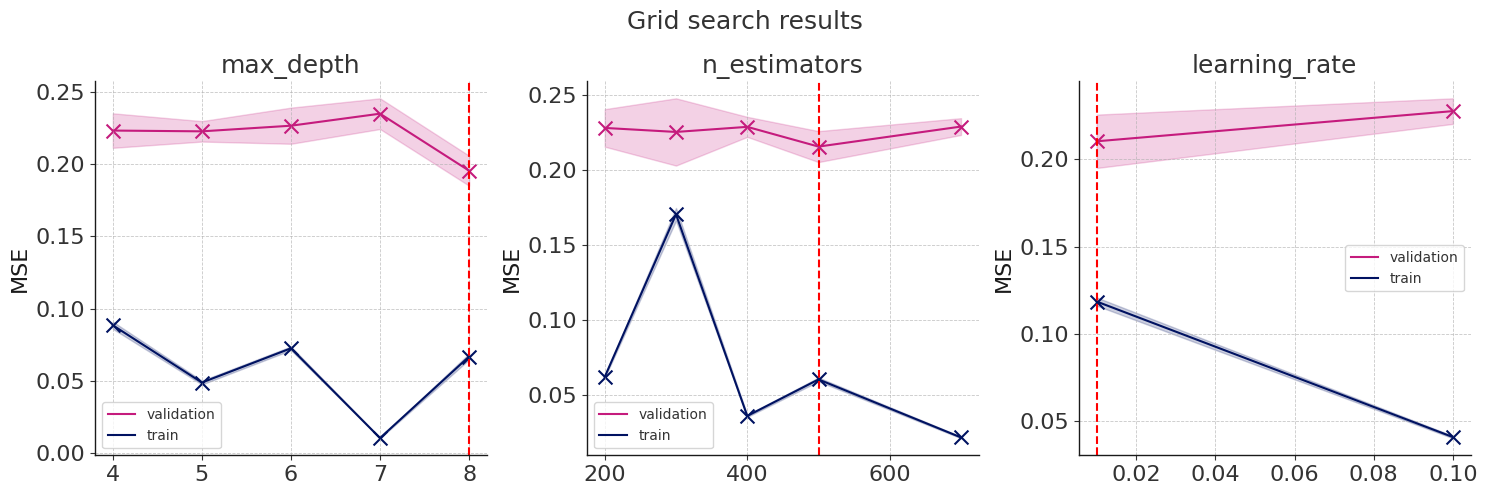

In [9]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

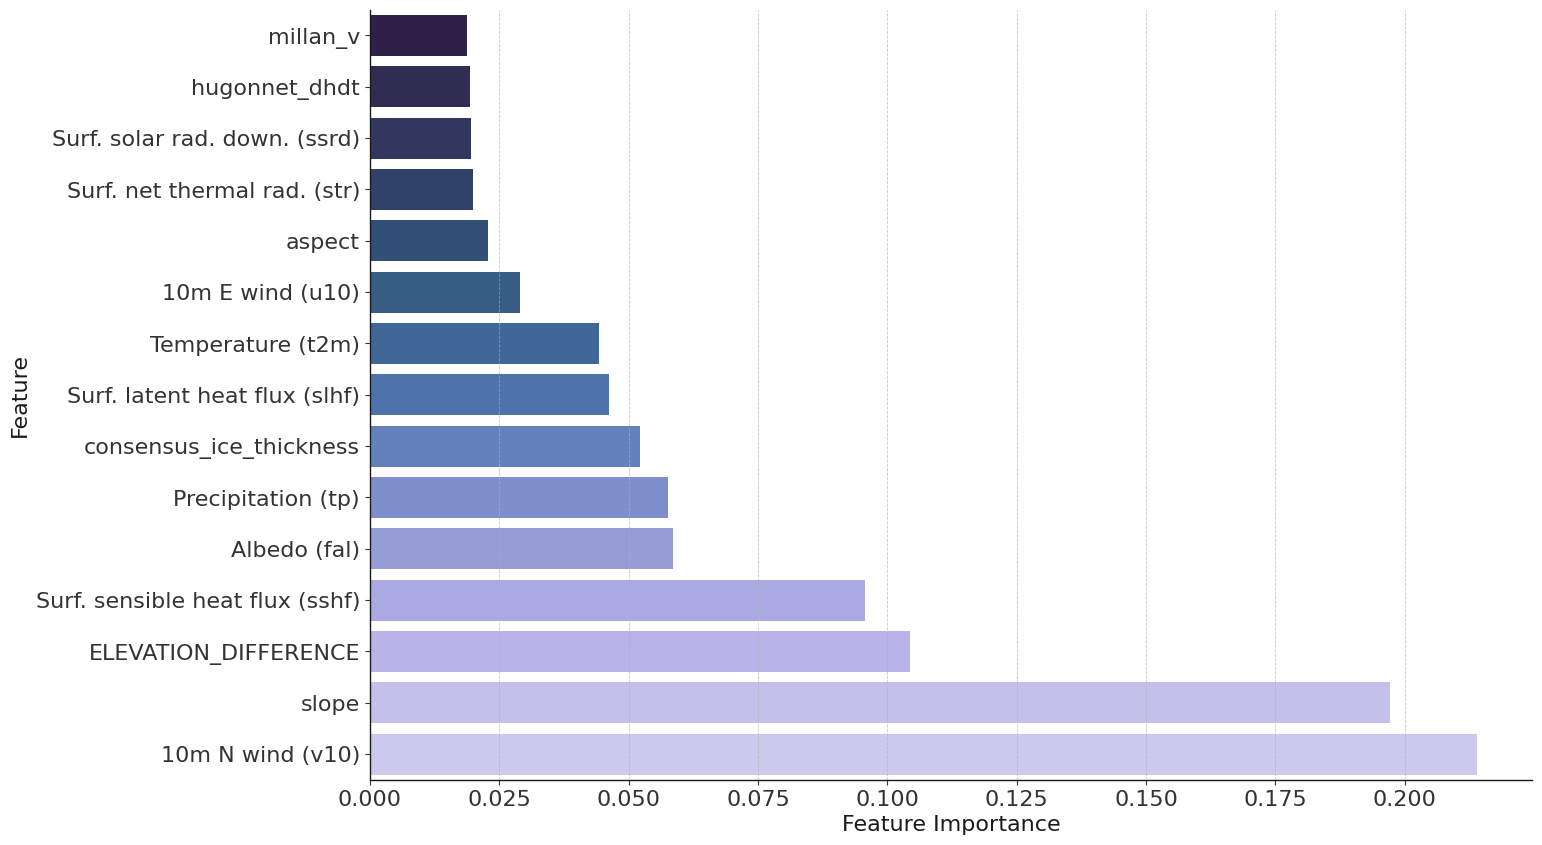

In [10]:
FIPlot(best_estimator, feature_columns, vois_climate)

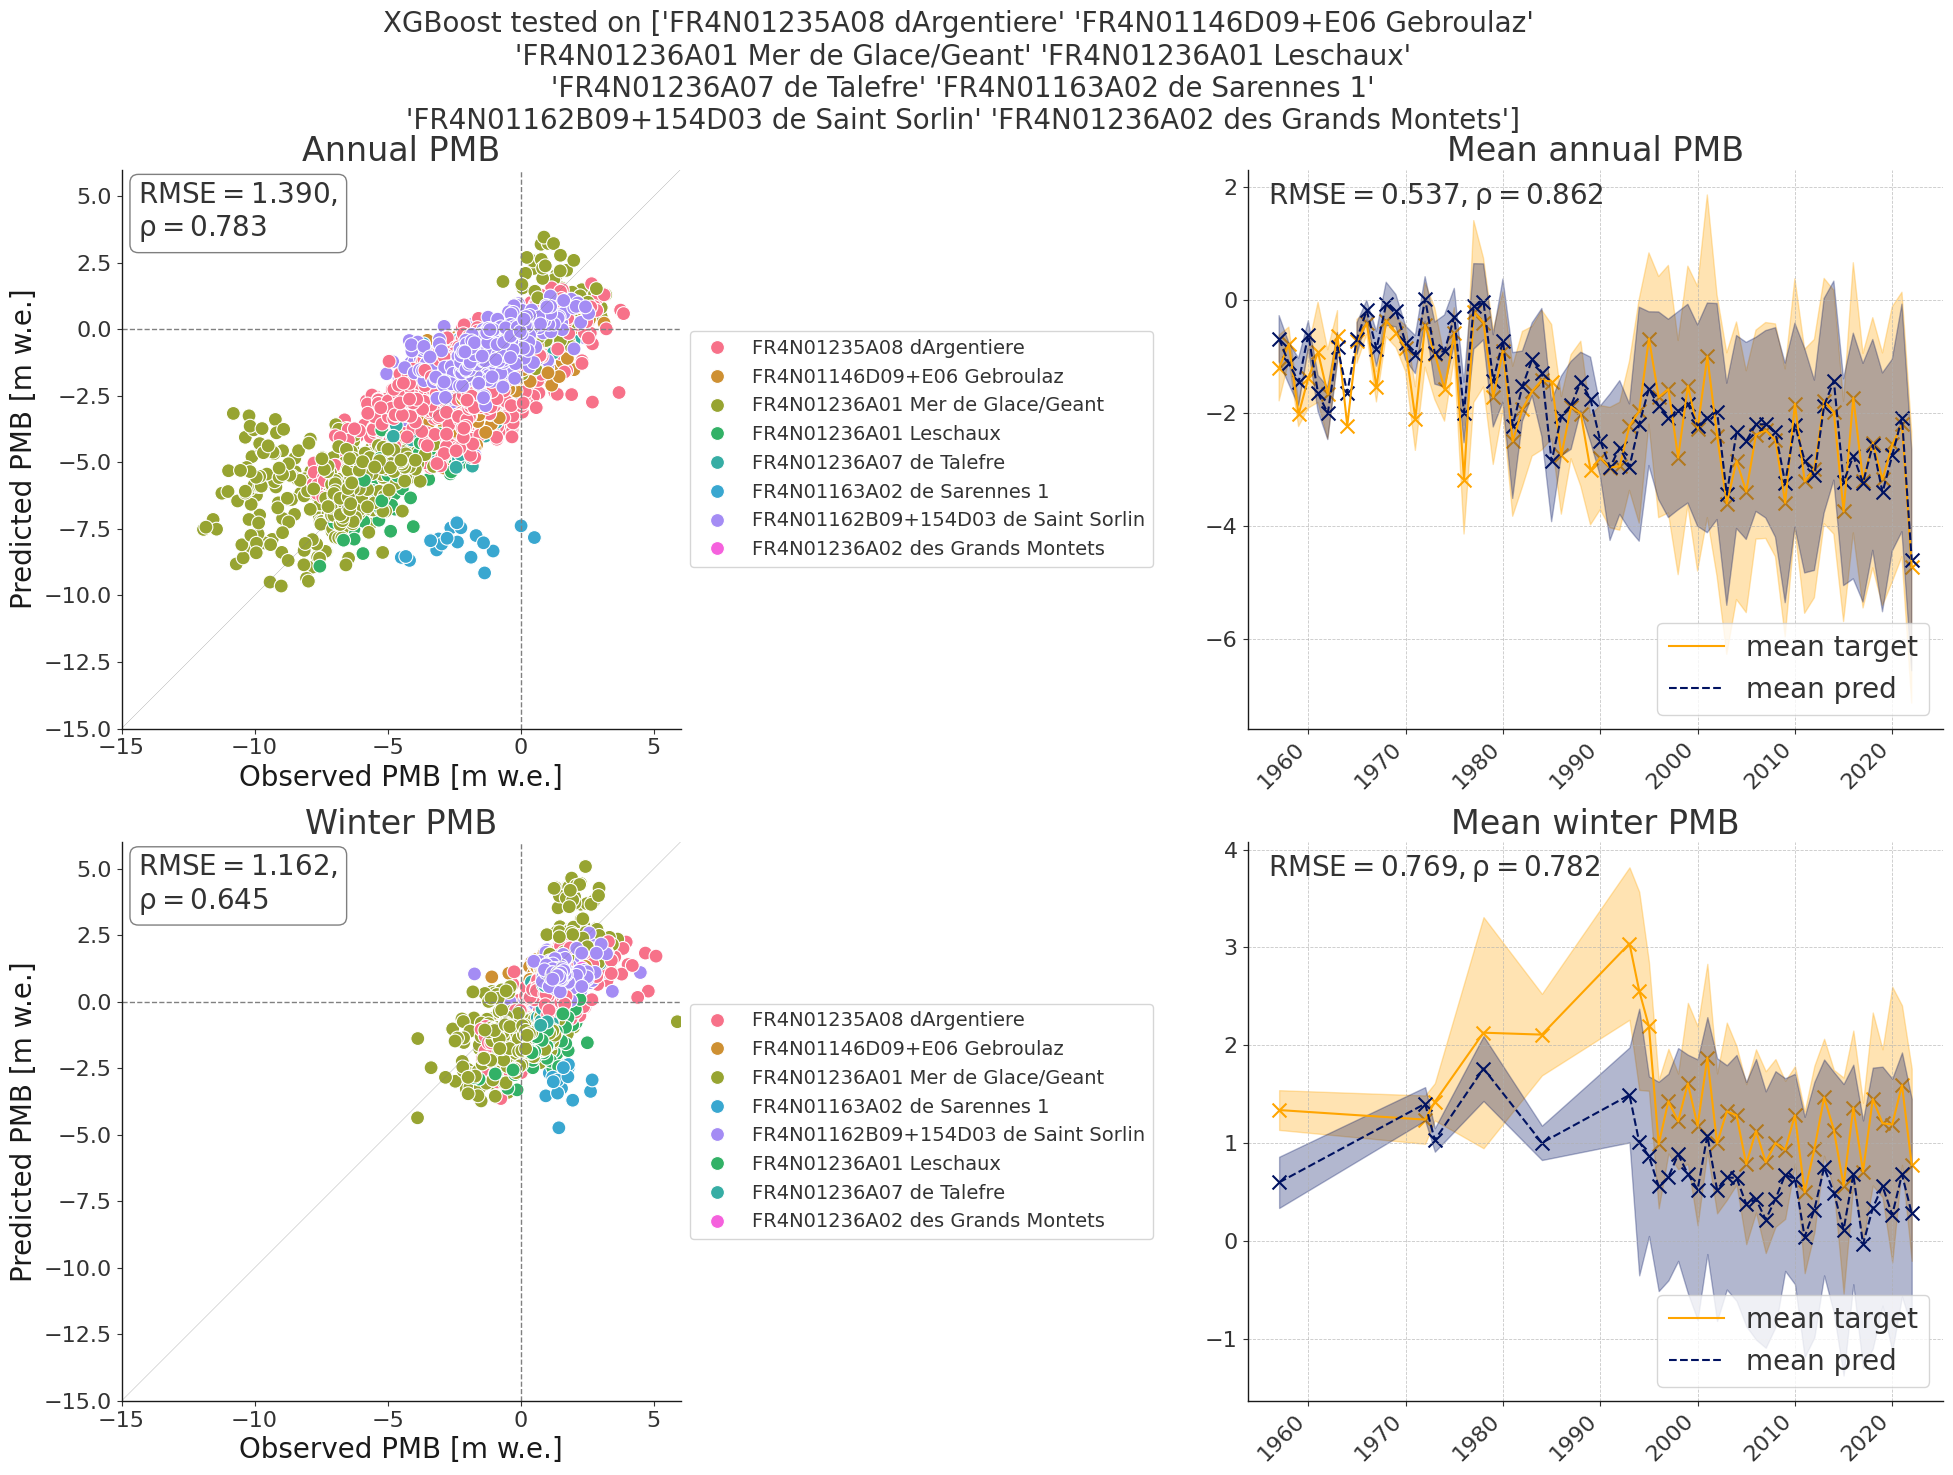

In [11]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

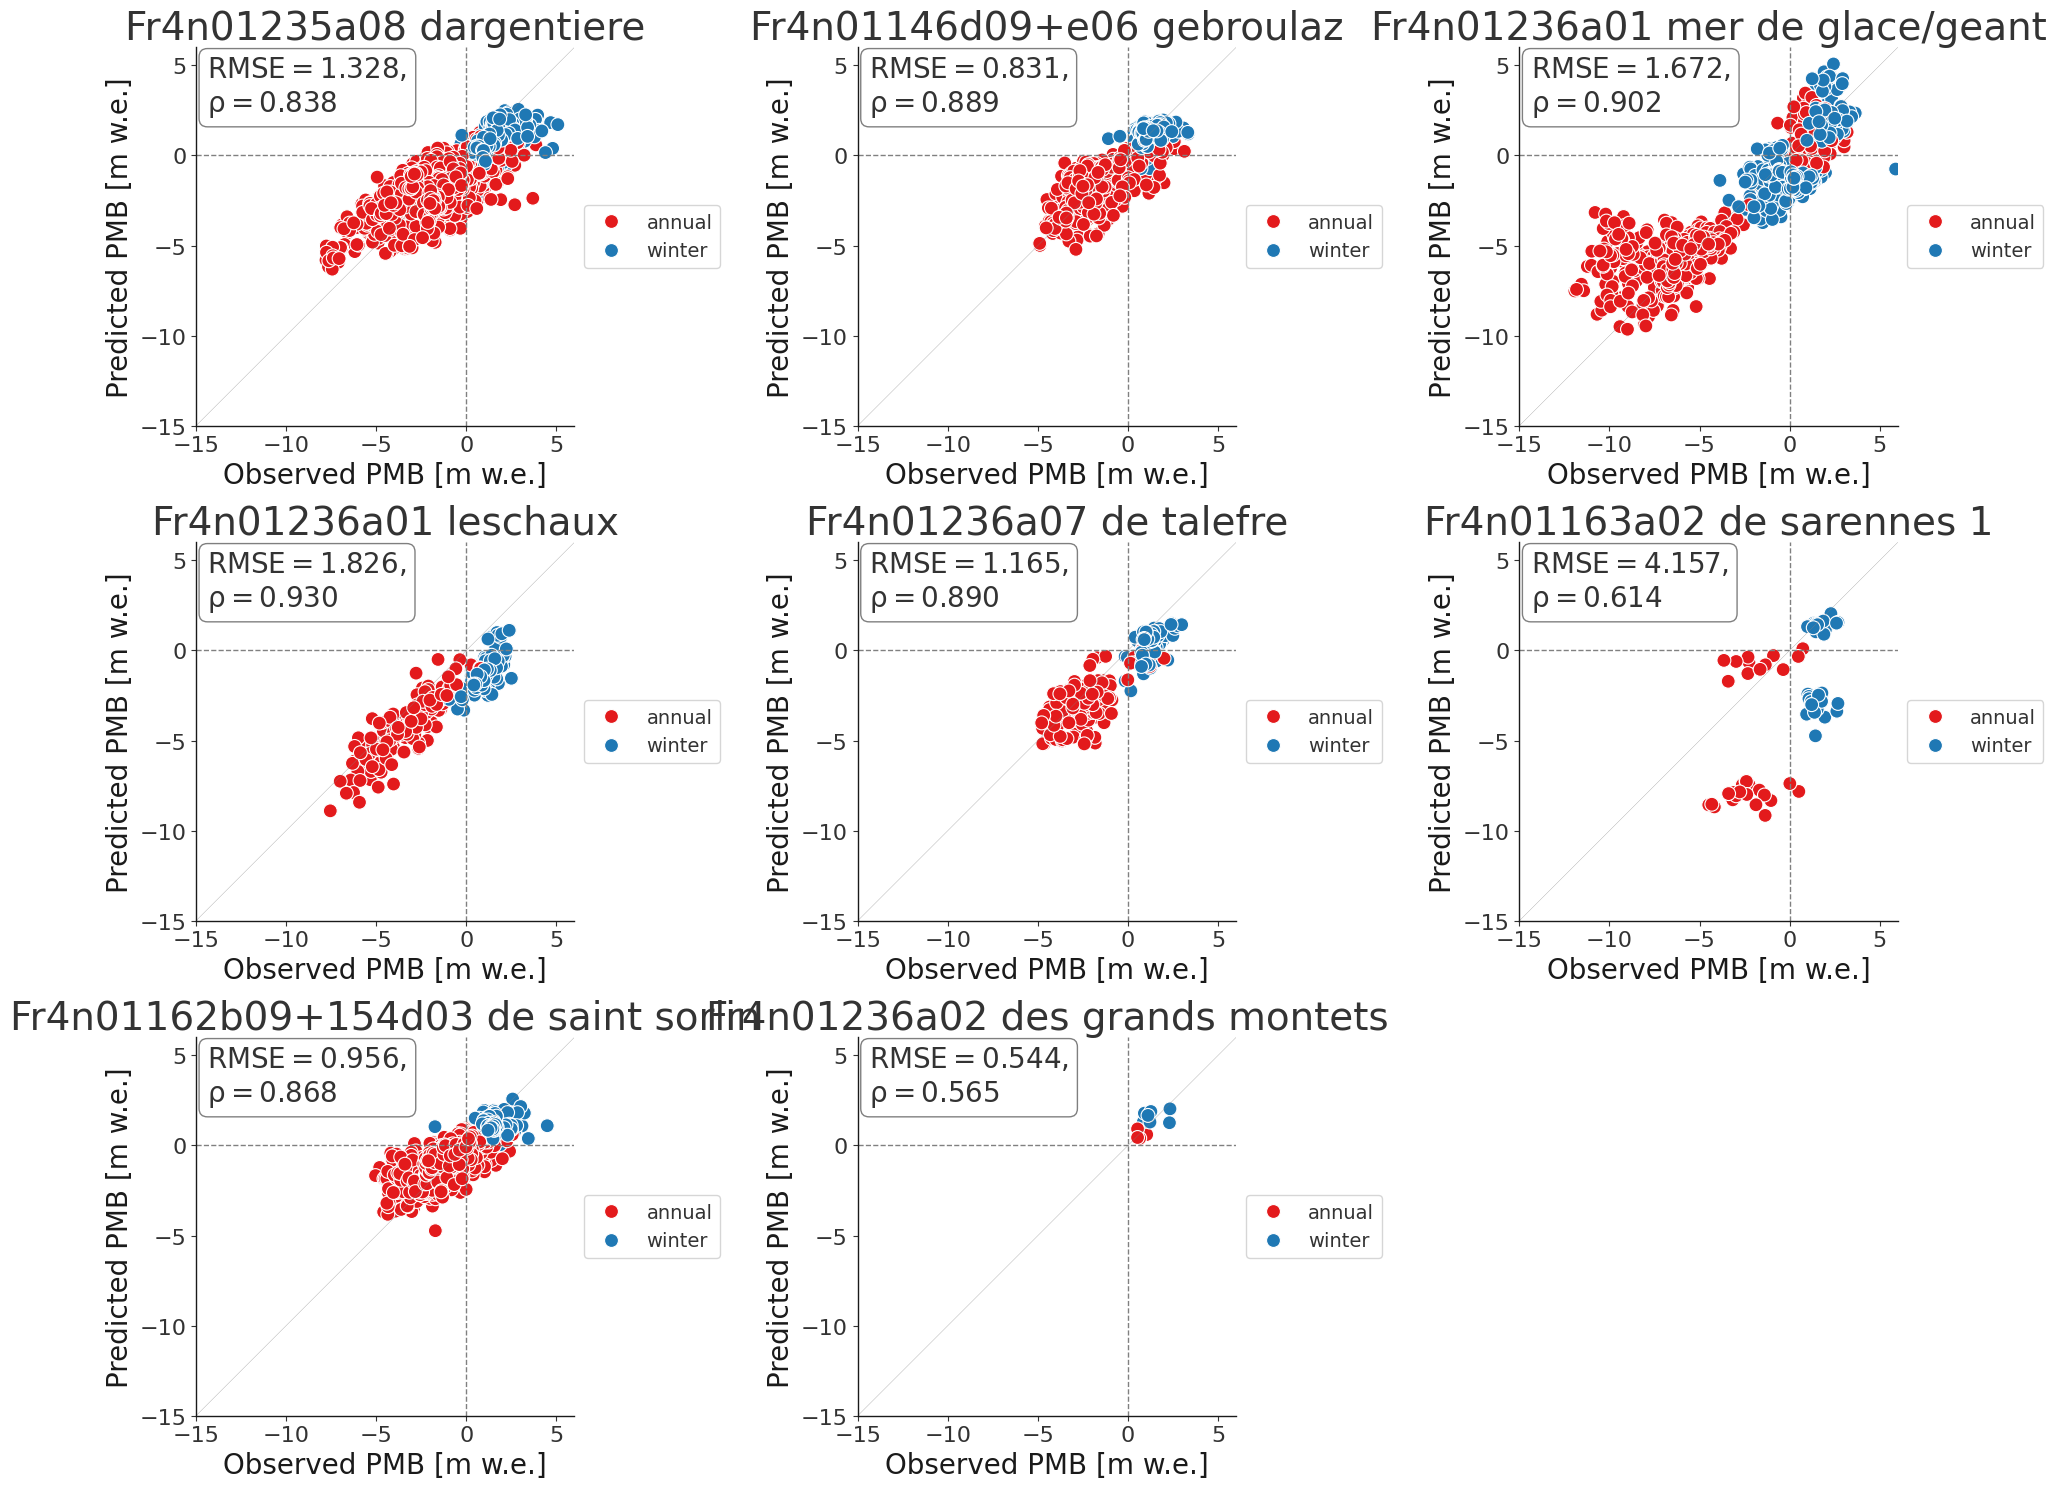

In [12]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

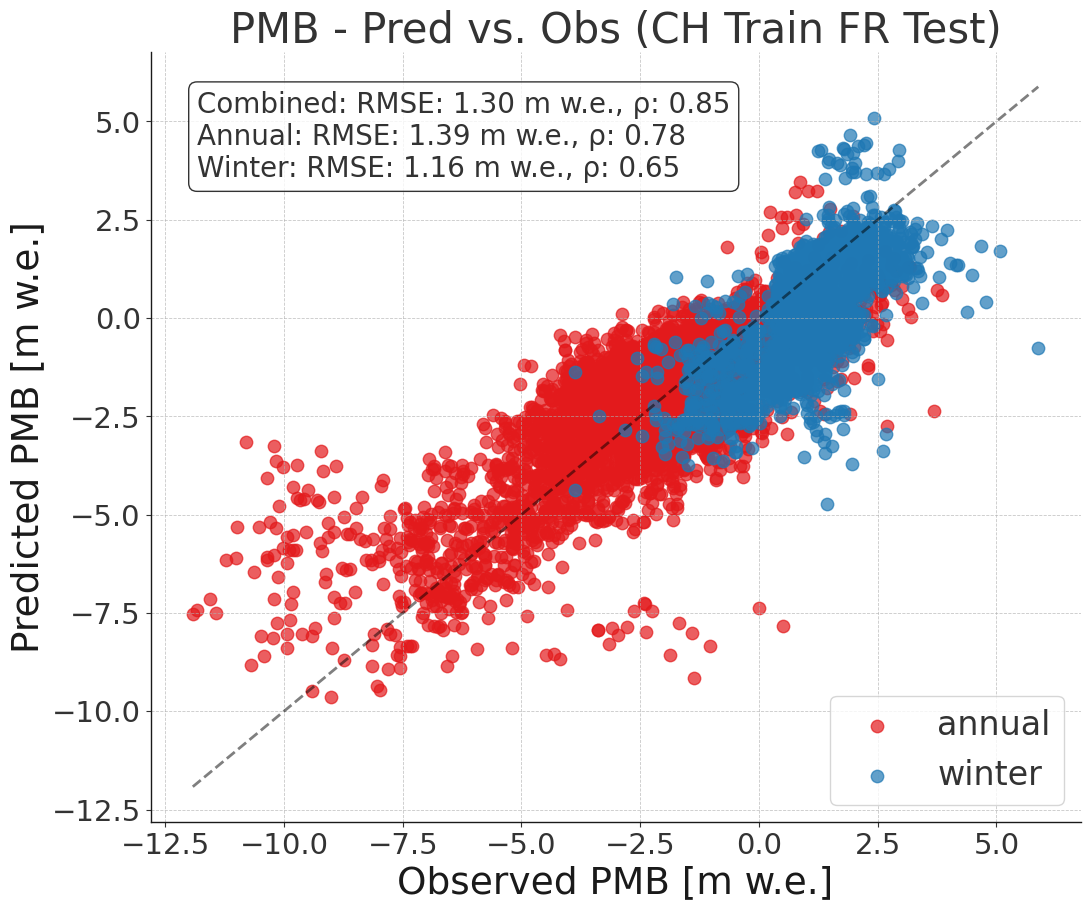

In [13]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train FR Test', include_summer = False)

,target,YEAR,POINT_ID,GLACIER,pred,PERIOD,pmb_diff
ID,,,,,,,
1174,-2.25,2010,sarennes_complete_annual_2010_1,FR4N01163A02 de Sarennes 1,-7.459177,annual,5.209177
1533,5.88,2011,mdg_langue_winter_smb_abl_2011_Langue_setup2009_4,FR4N01236A01 Mer de Glace/Geant,-0.754025,winter,6.634025
1975,-1.68,2013,sarennes_complete_annual_2013_1,FR4N01163A02 de Sarennes 1,-7.750680,annual,6.070680
2470,-3.16,2015,sarennes_complete_annual_2015_1,FR4N01163A02 de Sarennes 1,-8.292089,annual,5.132089
4393,3.69,1994,Argentiere_annual_smb_accu_1994_acum_setup1994_5,FR4N01235A08 dArgentiere,-2.376153,annual,6.066153
4394,2.69,1994,Argentiere_annual_smb_accu_1994_acum_setup1994_6,FR4N01235A08 dArgentiere,-2.736318,annual,5.426318
4439,-1.04,1994,sarennes_complete_annual_1994_2,FR4N01163A02 de Sarennes 1,-8.331896,annual,7.291896
4477,1.95,1994,sarennes_complete_winter_1994_2,FR4N01163A02 de Sarennes 1,-3.703612,winter,5.653612
4563,0.51,1995,sarennes_complete_annual_1995_2,FR4N01163A02 de Sarennes 1,-7.825183,annual,8.335183


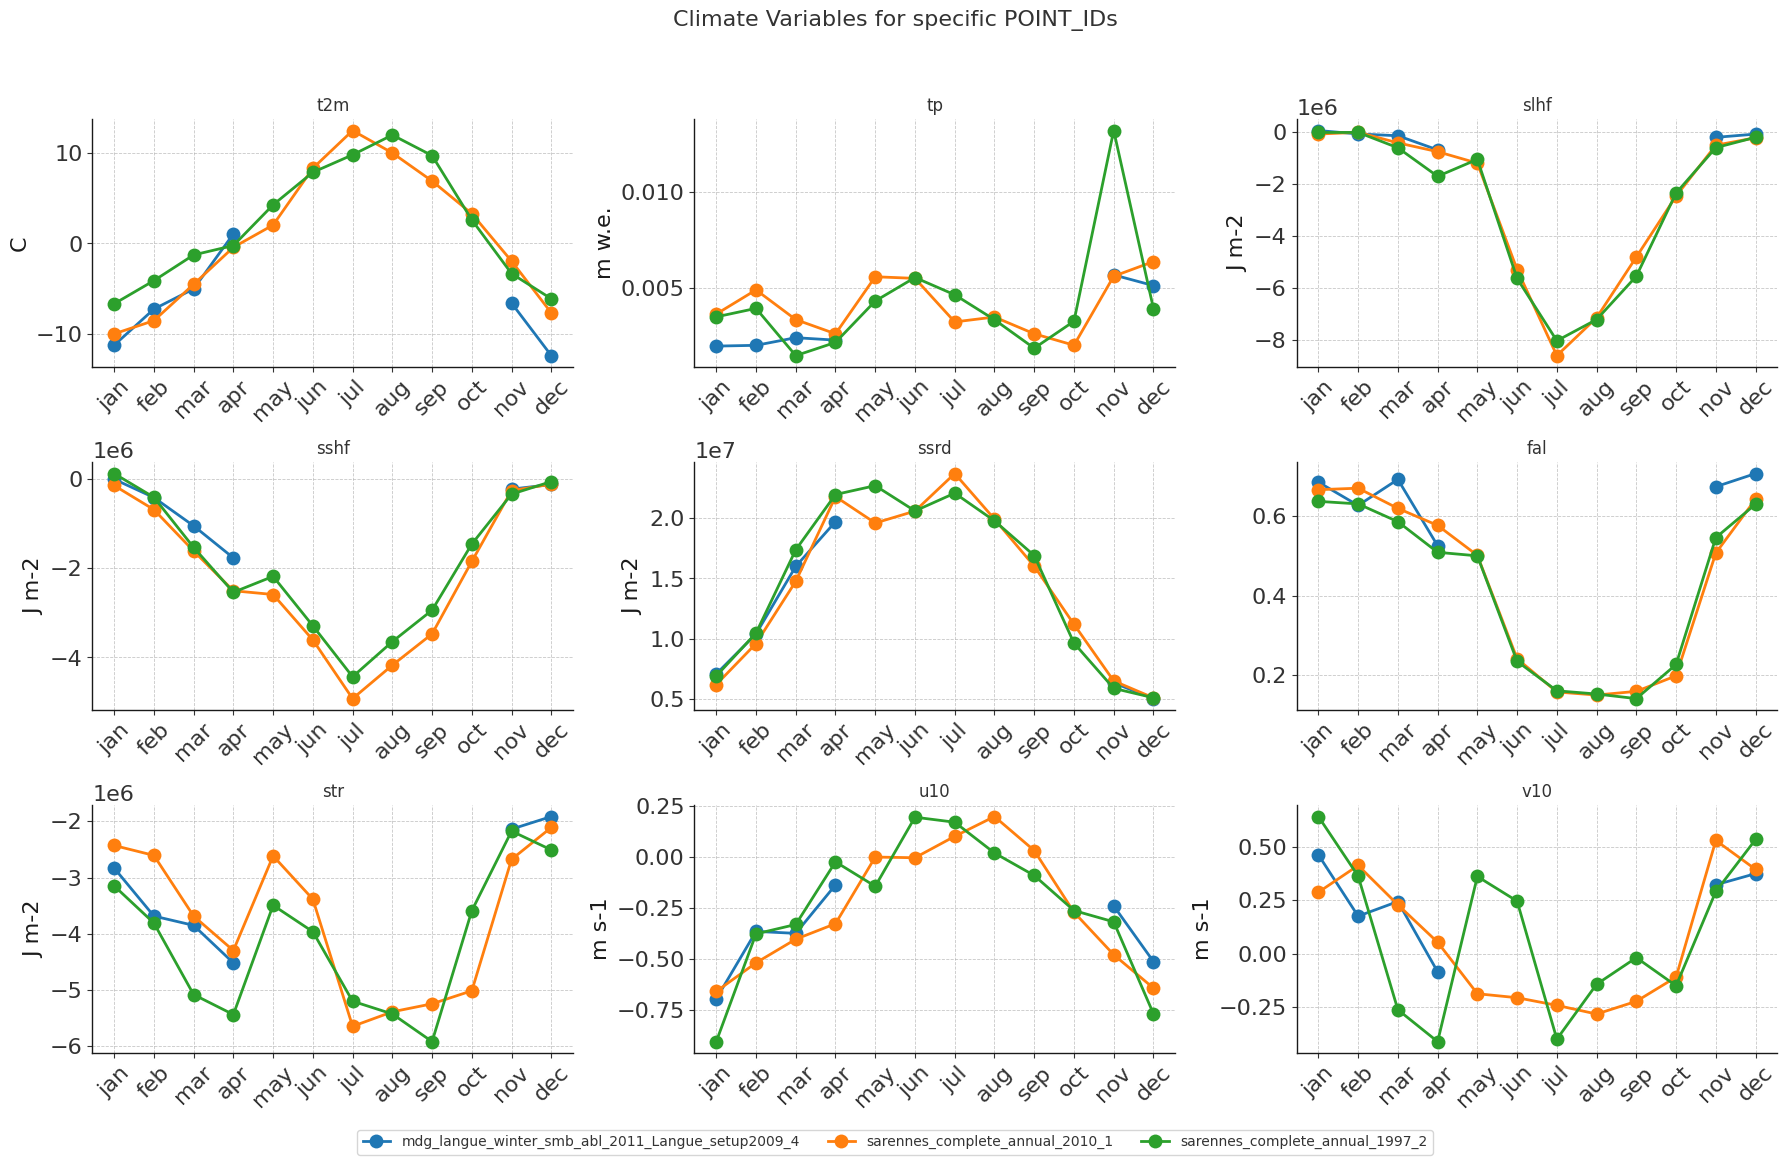

In [15]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 5)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = ['mdg_langue_winter_smb_abl_2011_Langue_setup2009_4',
             'sarennes_complete_annual_2010_1',
             'sarennes_complete_annual_1997_2'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_FR_CH,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)